In [4]:
import kagglehub
import torch

# Download latest version
#path = kagglehub.dataset_download("yasserh/uber-fares-dataset")

#print("Path to dataset files:", path)

c:\Coding\Uber Prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For splitting the data and evaluating the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# For the regression model
from sklearn.ensemble import GradientBoostingRegressor

# For saving the trained model
import joblib

data_path = "uber.csv"  
df = pd.read_csv(data_path)

df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
print("Dataset info:")
df.info()

print("\nSummary statistics:")
df.describe()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB

Summary statistics:


,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


 ## Data Cleaning & Preprocessing
 
 We now perform some cleaning steps:
 
 - **Missing Values:** Drop any rows with missing values.
 - **Fare Amount:** Ensure we only keep rows with a positive fare.
 - **Passenger Count:** Remove trips with zero or implausibly high passenger counts.
 - **Geographic Filtering:** Since we are dealing with NYC taxi trips, we filter coordinates to a reasonable bounding box.
 - **Datetime Conversion:** Convert the pickup datetime column to a `datetime` type.

In [7]:
# Drop rows with missing values
df.dropna(inplace=True)

# Keep only trips with a positive fare
df = df[df.fare_amount > 0]

# Filter out rows with an unreasonable number of passengers (e.g., 0 or >6)
df = df[(df.passenger_count > 0) & (df.passenger_count <= 6)]

# Apply geographic filters (approximate NYC region, adjust as necessary)
df = df[(df.pickup_latitude >= 40) & (df.pickup_latitude <= 42)]
df = df[(df.pickup_longitude >= -75) & (df.pickup_longitude <= -72)]
df = df[(df.dropoff_latitude >= 40) & (df.dropoff_latitude <= 42)]
df = df[(df.dropoff_longitude >= -75) & (df.dropoff_longitude <= -72)]

# Convert pickup_datetime to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

print("Cleaned dataset shape:", df.shape)

Cleaned dataset shape: (195100, 9)


## 5. Feature Engineering
 
 We will now create some new features:
 
 1. **Distance Calculation:** We use the Haversine formula to compute the great-circle distance (in kilometers) between the pickup and dropoff points.
 2. **Datetime Features:** Extract hour, day, month, and day-of-week from the pickup datetime.
 
 These features can help capture spatial and temporal patterns in the data.

In [8]:
# Define the haversine distance function
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance (in kilometers) between two points 
    on the earth (specified in decimal degrees).
    """
    # convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # compute differences
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers.
    return c * r

In [9]:
# Create a new feature for trip distance in km
df['distance_km'] = haversine_distance(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude']
)

# Create additional time-based features from pickup_datetime
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

# Preview the new features
df[['pickup_datetime', 'distance_km', 'hour', 'day', 'month', 'day_of_week']].head()

,pickup_datetime,distance_km,hour,day,month,day_of_week
0,2015-05-07 19:52:06+00:00,1.683323,19,7,5,3
1,2009-07-17 20:04:56+00:00,2.457590,20,17,7,4
2,2009-08-24 21:45:00+00:00,5.036377,21,24,8,0
3,2009-06-26 08:22:21+00:00,1.661683,8,26,6,4
4,2014-08-28 17:47:00+00:00,4.475450,17,28,8,3


 ## 6. Prepare Data for Modeling
 
 We select our features and target variable. In this example, we use:
 
 - **Features:** passenger_count, distance_km, hour, day, month, day_of_week
 - **Target:** fare_amount

In [10]:
# Define features and target variable
features = ['passenger_count', 'distance_km', 'hour', 'day', 'month', 'day_of_week']
X = df[features]
y = df['fare_amount']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 156080
Testing samples: 39020


## 7. Model Training

 We will train a Gradient Boosting Regressor. This model can capture nonlinear relationships and interactions between features.
 
 You may experiment with other models (e.g., Random Forest, XGBoost) or tune the hyperparameters as needed.


In [11]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

Test RMSE: 4.80


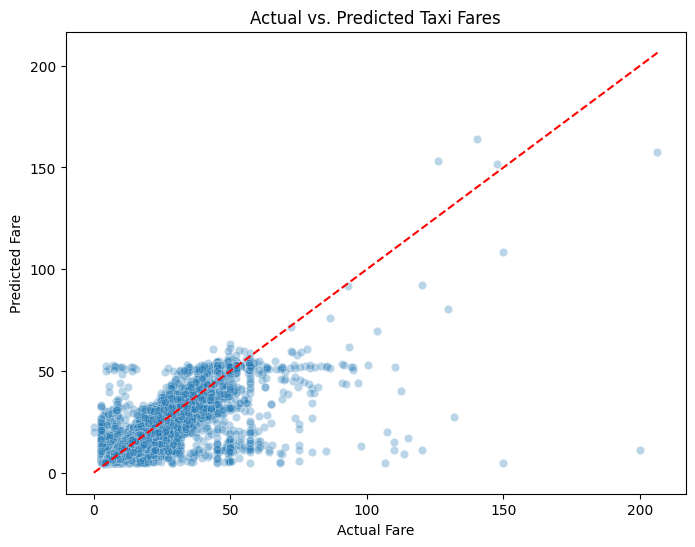

In [12]:
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f}")

# Optionally, plot actual vs. predicted fares
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual vs. Predicted Taxi Fares")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

## Save the Model

Now that we have a trained model, we can save it to disk. This model file (`taxi_fare_model.pkl`) can later be loaded in a web application to serve real-time predictions.


In [13]:
# Save the model using joblib
model_filename = 'taxi_fare_model.pkl'
joblib.dump(model, model_filename)
print(f"Model saved as {model_filename}")

Model saved as taxi_fare_model.pkl


## Making a Sample Prediction

Let’s demonstrate a sample prediction using one record from the test set.


In [14]:
# Select a sample from the test set
sample_data = X_test.iloc[0:1]
print("Sample features:")
print(sample_data)

# Predict fare for the sample
predicted_fare = model.predict(sample_data)
print("\nPredicted fare:", predicted_fare[0])

Sample features:
        passenger_count  distance_km  hour  day  month  day_of_week
169939                1     3.869752    11   11      3            2

Predicted fare: 12.874759180851585
